# 3 - Sentiment Analysis

### Libraries and Imports

In [1]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import IPython.display as display

In [2]:
path = "D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_clean.parquet"
df_clean = pd.read_parquet(path)
print(f"df shape: {df_clean.shape}")
df_clean.head(2)

df shape: (660848, 15)


,ID,app,score,review_text,review_text_clean,review_date,year,thumbs_up,replied,reply_text,reply_text_clean,reply_date,time_to_reply(h),app_version_head,app_version_detail
0,1,Santander,4,What is the policy in regard to root/custom ROMs?,what is the policy in regard to root/custom roms?,2025-12-09 03:08:56,2025,0,0,None,None,NaT,NaN,5,29.0
1,2,Santander,1,Depositing a cheque most difficult thing to do...,depositing a cheque most difficult thing to do...,2025-12-08 23:44:12,2025,0,0,None,None,NaT,NaN,5,29.0


## 3.1 - Building Sentiment Analysis

### 3.1.1 - Sentiment Intensity Analyzer using VADER

Sentiment analysis will be performed using VADER's `SentimentIntensityAnalyzer`.

In [ ]:
def add_vader_sentiment(
    df: pd.DataFrame,
    text_col: str = "review_text",
    score_col: str = "review_sentiment",
    analyzer: SentimentIntensityAnalyzer | None = None,
    inplace: bool = True,
):
    """
    Adds two columns:
      - '*_sentiment': VADER compound score in [-1, 1] (NaN for empty/invalid)
      - '*_sentiment_label': 'positive' | 'negative' | 'neutral' | 'undefined'
      - Consistent (int): 1 if sentiment label aligns with numeric score, else 0
    """
    if not inplace:
        df = df.copy()

    if analyzer is None:
        analyzer = SentimentIntensityAnalyzer()

    # 1) sentiment scores (numeric; NaN for undefined)
    def _score(text):
        if not isinstance(text, str) or text.strip() == "":
            return np.nan
        return analyzer.polarity_scores(text)["compound"]

    df[score_col] = [_score(t) for t in df[text_col]]

    # 2) sentiment labels
    def _label(s):
        if pd.isna(s):
            return "undefined"
        if s >= 0.10:
            return "positive"
        if s <= -0.10:
            return "negative"
        return "neutral"

    label_col = f"{score_col}_label"
    df[label_col] = pd.Categorical(
        [_label(s) for s in df[score_col]],
        categories=["negative", "neutral", "positive", "undefined"]
    )
    
    # 3) Consistency check
    def _consistent(row):
        if row[label_col] == "positive" and row["score"] in (0, 1):
            return 0
        if row[label_col] == "negative" and row["score"] in (4, 5):
            return 0
        return 1

    df["Consistent"] = df.apply(_consistent, axis=1).astype(int)

    # Save Final Dataframe
    save_path = "D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_sentiment.parquet"
    df.to_parquet(save_path, index=False)
    print(f"✅ Dataframe saved in {save_path}")
    print(f"df saved shape: {df.shape}")

    return df

In [4]:
df_clean = add_vader_sentiment(df_clean, text_col="review_text_clean", score_col="review_sentiment")
df_clean = add_vader_sentiment(df_clean, text_col="reply_text_clean", score_col="reply_sentiment")

✅ Dataframe saved in ../assets/intermediate_dfs/df_sentiment.parquet
df saved shape: (660848, 18)
✅ Dataframe saved in ../assets/intermediate_dfs/df_sentiment.parquet
df saved shape: (660848, 20)


In [5]:
print("Review Sentiment Label:")
print(df_clean['review_sentiment_label'].value_counts().sum)
print("------------------")
print(df_clean['reply_sentiment_label'].value_counts().sum)

Review Sentiment Label:
<bound method Series.sum of review_sentiment_label
positive     511359
neutral       81236
negative      68242
undefined        11
Name: count, dtype: int64>
------------------
<bound method Series.sum of reply_sentiment_label
undefined    553806
positive      99747
negative       4220
neutral        3075
Name: count, dtype: int64>


### 3.1.2 - Identification of Rows with Undefined Sentiment

The high number of replies with *undefined* sentiment corresponds to reviews that did not receive a reply, and therefore, no sentiment can be assigned.

The subset of reviews with *undefined* sentiment scores will be explored.

In [6]:
subset = df_clean.loc[df_clean['review_sentiment_label'].eq('undefined'), ['ID','score', 'review_text','review_text_clean', 'review_sentiment_label']]
sample = subset.sample(n=min(20, len(subset)), random_state=42)
sample

,ID,score,review_text,review_text_clean,review_sentiment_label
422460,563705,4,None,None,undefined
106165,127319,5,None,None,undefined
430683,571928,1,None,None,undefined
431683,572928,1,None,None,undefined
277375,340060,4,None,None,undefined
126605,147759,1,None,None,undefined
430556,571801,1,None,None,undefined
411660,552905,5,None,None,undefined
430471,571716,1,None,None,undefined
408525,549770,1,None,None,undefined


As observed, the cases with no sentiment score arise from the following situations:  

1. Reviews that are empty.  
2. Reviews that contain only emojis (which were removed during preprocessing before applying VADER).  
3. Reviews written in unrecognized or non-standard characters.

In [7]:
# Make sure undefined_text is a DataFrame
undefined_text = df_clean[df_clean['review_sentiment_label'] == 'undefined']
# Count total reviews per app
total_reviews_by_app = df_clean.groupby('app').size()
# Count undefined sentiment per app
undefined_text_by_app = undefined_text.groupby('app').size()
# Calculate percentage
undefined_percent = (undefined_text_by_app / total_reviews_by_app * 100).round(2)

# Combine into a single DataFrame
summary = pd.DataFrame({
    'undefined_count': undefined_text_by_app,
    'total_reviews': total_reviews_by_app,
    'percent_undefined': undefined_percent
}).fillna(0).astype({'undefined_count': int, 'total_reviews': int})

# Add total row
total_row = pd.DataFrame({
    'undefined_count': [summary['undefined_count'].sum()],
    'total_reviews': [summary['total_reviews'].sum()],
    'percent_undefined': [(summary['undefined_count'].sum() / summary['total_reviews'].sum() * 100).round(2)]
}, index=['TOTAL'])

summary = pd.concat([summary, total_row])

# Show result
summary

,undefined_count,total_reviews,percent_undefined
Barclays,1,189514,0.0
HSBC,0,35816,0.0
Lloyds,2,109231,0.0
Monzo,0,20939,0.0
Revolut,8,242622,0.0
Santander,0,62726,0.0
TOTAL,11,660848,0.0


When examining the total numbers across all bank apps, reviews with undefined sentiment represent only **11 out of 660,848 reviews**, which is approximately **0.002% of the dataset**. Given their negligible proportion, these "undefined" sentiment cases will be ignored for the purposes of this sentiment analysis.

## 3.2 - Competitive Analysis of Review Text Sentiment

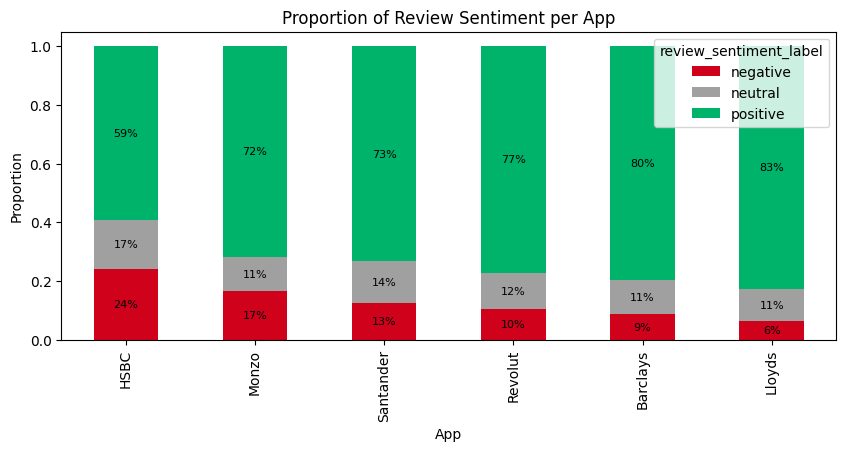

In [8]:
# Keep only wanted labels and make them the only categories (order set too)
wanted = ['negative', 'neutral', 'positive']
valid = df_clean[df_clean['review_sentiment_label'].isin(wanted)].copy()
valid['review_sentiment_label'] = pd.Categorical(valid['review_sentiment_label'],
                                                 categories=wanted, ordered=True)

# Count and proportion – only observed categories will be used (no 'undefined' column)
sentiment_counts = (valid
    .groupby(['app', 'review_sentiment_label'], observed=True)
    .size()
    .unstack(fill_value=0))

sentiment_props = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sort by share of negatives (desc)
sentiment_props = sentiment_props.sort_values(by='negative', ascending=False)

# Colors only for the columns that actually exist
color_map = {'negative': '#d0021b', 'neutral': '#a0a0a0', 'positive': '#00b36b'}
colors = [color_map[c] for c in sentiment_props.columns]  # safe now

# Plot
ax = sentiment_props.plot(kind='bar', stacked=True, figsize=(10, 4), color=colors)
ax.set_xlabel('App'); ax.set_ylabel('Proportion'); ax.set_title('Proportion of Review Sentiment per App')

# annotate bars
for p in ax.patches:
    if p.get_height() > 0.02:
        ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2,
                f"{p.get_height():.0%}", ha='center', va='center', fontsize=8)

plt.show()

### Review Sentiment Analysis by App

Sentiment analysis results **align closely with average review scores**, confirming that **scores are strong predictors of text sentiment**. Apps with higher average ratings (Lloyds: 83% positive, Barclays: 80% positive) show predominantly positive sentiment, while those with lower ratings (HSBC: 24% negative) exhibit more negative sentiment.

**Key consideration:** While sentiment analysis may appear redundant given existing scores, it can still add value by identifying **score-sentiment inconsistencies**—cases where users leave high/low scores but write contradictory text, revealing nuanced feedback or potential data quality issues.

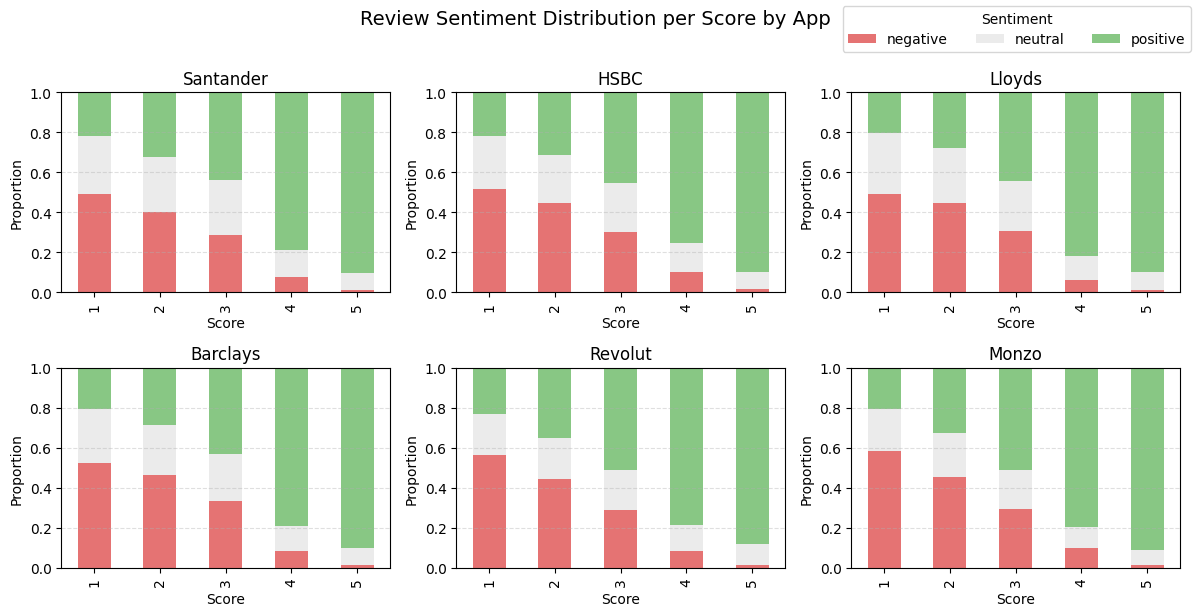

In [9]:
valid = df_clean.copy()

# ensure columns exist and are in the right types
valid['score'] = pd.to_numeric(valid['score'], errors='coerce')
valid = valid.dropna(subset=['score'])
valid['review_sentiment_label'] = valid['review_sentiment_label'].astype('category')

apps = valid['app'].dropna().unique()
sentiment_order = ['negative', 'neutral', 'positive']
COLORS = {'negative': '#e57373', 'neutral': '#ebebeb', 'positive': '#88c784'}

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, app_name in enumerate(apps):
    ax = axes[i]
    app_data = valid.loc[valid['app'] == app_name]

    # counts per score x sentiment
    counts = (
        app_data
        .groupby(['score', 'review_sentiment_label'], observed=True) 
        .size()
        .unstack(fill_value=0)
        .reindex(columns=sentiment_order, fill_value=0)               
        .sort_index()
    )

    # proportions per score
    props = counts.div(counts.sum(axis=1), axis=0).fillna(0)

    # plot
    props.plot(kind='bar', stacked=True,
               color=[COLORS[s] for s in sentiment_order],
               ax=ax, legend=False)

    ax.set_title(f"{app_name}")
    ax.set_xlabel("Score"); ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1); ax.grid(axis='y', linestyle='--', alpha=0.4)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, sentiment_order, title='Sentiment', loc='upper right', ncol=3)
plt.suptitle("Review Sentiment Distribution per Score by App", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Sentiment-Score Consistency Analysis

The visualizations confirm three key patterns:

1. **Strong score-sentiment correlation**: Negative sentiment decreases systematically as review scores increase across all apps
2. **Consistent cross-app patterns**: The sentiment distribution by score remains remarkably similar across different banking apps
3. **Notable inconsistencies**: Some score-1 reviews show positive sentiment, revealing interesting edge cases

**Root causes of score-sentiment mismatches:**

**User error (accidental scoring)**: Comments like "best of the best" or "easy to manage accounts" paired with 1-star ratings suggest unintentional score selection

**Comparative sentiment confusion**: Users often praise previous app versions while criticizing current ones (e.g., "used to be a 5 star app until last update"), which confuses sentiment models into detecting overall positive language

**Irony and sarcasm**: Comments like "love being inconvenienced, it's first class" or "absolute joke...nice if it were possible to bank like other people in the 21st century" use positive words to convey negative meaning

**Mitigation strategies:**
- Advanced NLP or LLM-based models could better handle comparative statements (issue #2) and detect sarcasm (issue #3), though sarcasm remains challenging even for sophisticated models
- For obvious scoring errors (issue #1), corrections are theoretically possible but require subjective judgment about what text should correspond to each score level

Given the purpose of the next stage of the project - i.e., 'Topic Modeling' - is to generalize what are the main motives for users to be (dis)satified with the App in the reviews they share, we will **discart all the `inconsistent_cases`** (i.e., negative score / positive sentiment or positive score / negative sentiment) **from the topic modeling analysis**. 

In the end, this analysis on the inconsistent cases, proves that **sentiment analysis can still play a relevant role prior to topic modeling**, even when we already have a score, in order to eliminate records that could generate unnecessary “noise” and harm the effectiveness of the model. This is especially relevant when using less advanced NLP models that, given their limitations, can lead to the kind of misclassifications we’ve seen above.

## 3.3 - Competitive Analysis of Reply Text Sentiment

Before proceeding to topic modeling, the sentiment of replies — when present — will be analyzed to understand how banks respond to user reviews.

This analysis will focus on two key questions:

- Are there differences in the overall positivity of the tone used by each bank in their replies?  
- How does the tone of the reply vary depending on the score provided by the user?

**Analysis of Overall Positivity in Bank Replies:**  

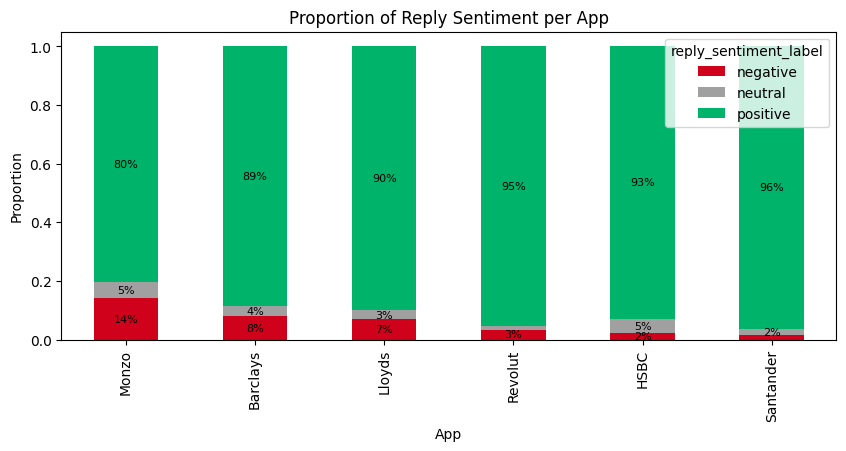

In [10]:
# Keep only wanted labels and make them the only categories (order set too)
wanted = ['negative', 'neutral', 'positive']
valid = df_clean[df_clean['reply_sentiment_label'].isin(wanted)].copy()
valid['reply_sentiment_label'] = pd.Categorical(valid['reply_sentiment_label'],
                                                 categories=wanted, ordered=True)

# Count and proportion – only observed categories will be used (no 'undefined' column)
sentiment_counts = (valid
    .groupby(['app', 'reply_sentiment_label'], observed=True)
    .size()
    .unstack(fill_value=0))

sentiment_props = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sort by share of negatives (desc)
sentiment_props = sentiment_props.sort_values(by='negative', ascending=False)

# Colors only for the columns that actually exist
color_map = {'negative': '#d0021b', 'neutral': '#a0a0a0', 'positive': '#00b36b'}
colors = [color_map[c] for c in sentiment_props.columns]  # safe now

# Plot
ax = sentiment_props.plot(kind='bar', stacked=True, figsize=(10, 4), color=colors)
ax.set_xlabel('App'); ax.set_ylabel('Proportion'); ax.set_title('Proportion of Reply Sentiment per App')

# annotate bars
for p in ax.patches:
    if p.get_height() > 0.02:
        ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2,
                f"{p.get_height():.0%}", ha='center', va='center', fontsize=8)

plt.show()

### Bank Reply Sentiment Analysis

Unlike user reviews where sentiment strongly correlates with scores, **bank reply sentiment shows weaker correlation with app ratings**. Notably:

- **Lloyds** (highest user ratings) has the **highest negative reply sentiment** (7%), despite overall user satisfaction
- **HSBC** (lowest user ratings) shows the **second-lowest negative reply sentiment** (5%), suggesting more diplomatic response strategies
- **Revolut and Santander** exhibit the most positive reply sentiment (95-96%), indicating consistently upbeat customer service tone

This disconnect suggests that **reply sentiment reflects customer service strategy rather than app quality**—banks may adopt different approaches regardless of their app's performance, with some maintaining positivity even when addressing complaints, while others may be more candidly negative in their responses.

**Analysis of Reply Tone by User Score:**  

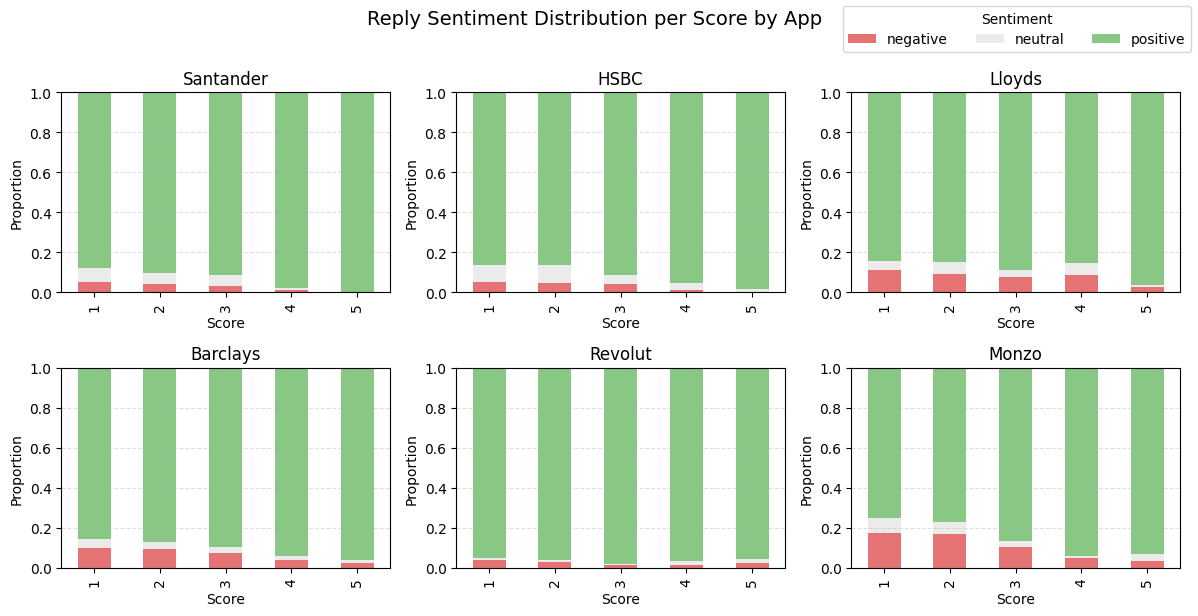

In [11]:
valid = df_clean.copy()

# ensure columns exist and are in the right types
valid['score'] = pd.to_numeric(valid['score'], errors='coerce')
valid = valid.dropna(subset=['score'])
valid['reply_sentiment_label'] = valid['reply_sentiment_label'].astype('category')

apps = valid['app'].dropna().unique()
sentiment_order = ['negative', 'neutral', 'positive']
COLORS = {'negative': '#e57373', 'neutral': '#ebebeb', 'positive': '#88c784'}

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, app_name in enumerate(apps):
    ax = axes[i]
    app_data = valid.loc[valid['app'] == app_name]

    # counts per score x sentiment
    counts = (
        app_data
        .groupby(['score', 'reply_sentiment_label'], observed=True) 
        .size()
        .unstack(fill_value=0)
        .reindex(columns=sentiment_order, fill_value=0)               
        .sort_index()
    )

    # proportions per score
    props = counts.div(counts.sum(axis=1), axis=0).fillna(0)

    # plot
    props.plot(kind='bar', stacked=True,
               color=[COLORS[s] for s in sentiment_order],
               ax=ax, legend=False)

    ax.set_title(f"{app_name}")
    ax.set_xlabel("Score"); ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1); ax.grid(axis='y', linestyle='--', alpha=0.4)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, sentiment_order, title='Sentiment', loc='upper right', ncol=3)
plt.suptitle("Reply Sentiment Distribution per Score by App", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Reply Sentiment by Review Score

The visualizations reveal clear patterns in how banks tailor reply sentiment to review scores:

1. **Negative reply sentiment concentrates in low-scoring reviews**: Banks use negative-toned language almost exclusively when responding to scores 1-3, with virtually no negative replies to 4-5 star reviews

2. **Lloyds and Monzo show higher negative reply rates across all scores**: These two banks employ more negative sentiment in responses compared to competitors, regardless of the original review score

**Implications**: Most banks maintain overwhelmingly positive reply language even when addressing complaints, but Lloyds and Monzo appear more willing to use realistic or problem-acknowledging language. To better understand this pattern, examining sample replies with negative sentiment would reveal whether this reflects authentic problem acknowledgment or different communication strategies.

In [12]:
# Filter negative sentiment replies: negative reply sentiment regardless of the score
neg_reply = df_clean[df_clean['reply_sentiment_label'] == 'negative']

# Random sample
sample_neg_reply= neg_reply[['app', 'score', 'review_text', 'review_sentiment_label','reply_text', 'reply_sentiment_label']].sample(n=15, random_state=42)
pd.set_option('display.max_colwidth', None)
display.display(sample_neg_reply)

,app,score,review_text,review_sentiment_label,reply_text,reply_sentiment_label
349951,Barclays,2,"I click on the app, and then a white screen appears, then it just goes back to my phone's home screen",neutral,"Hi Molly-ann, thanks for your review, I'm sorry you're having trouble. Can you tell me exactly what the issue is please and whether you're receiving any error codes or messages? - Adrian",negative
16423,Santander,3,"After 4 failed attempts at inputting otp, it is now asking for photo of id and face to unlock it, a bit over the top since I've had the old app for years with no need for this.",negative,"Hi Lee, sorry to hear you had trouble accessing the app. If you could contact our Digital Team on 0330 123 0209 they will be able to guide your further. ^EJ",negative
344281,Barclays,1,Everytime I open and log in I'm told please try again later. When its not possible to get to a bank or call this means I'm stuck waiting. Not impressed.,negative,"Hi Jason, I'm sorry to hear the app is causing frustration. Let us know if you are being shown any error codes at all. Also is this a new issue or has it been causing technical difficulties for a while? Let us know to see if we can re solve this for you. Thank you for your feedback - JP",negative
410839,Revolut,1,Got scammed online and they would not stop the payment even with a metal plan.,positive,"Hello! We're sorry to hear about the scam. Please reach out to us on our social media platforms (X, Instagram, Facebook) where we can assist you further on the DM. Alternatively, you can also email at us help@revolut.com, and one of our agents will promptly respond to your inquiry.",negative
429338,Revolut,1,"No longer trustworthy. I reported a very significant error related to currency exchange and have received no feedback whatsoever. Secondly, Revolut claim to prioritize customer support via the app, yet I am unable to even chat with customer service. Seems they now see themselves on par with legacy banks and act accordingly.",negative,Hi! We're sorry to hear about the disappointment. We'd like to assist you with your currency exchange. Let's check this via in-app chat. Get there by going to Profile>Help>Choose a category>Chat with us or write to us at help@revolut.com.,negative
18508,Santander,1,This app was working fine and then presumably after an update it doesn't work. I tried uninstall and reinstall but after 2 days it stopped working again.,negative,"Hi Katie, I'm sorry to hear about the problems with your app. If you have reinstalled and the problem persists, we recommend contacting our Digital Banking Team at 0330 123 0209 for assistance. ^JP",negative
272609,Barclays,5,"I find app is very efficient,I've had no problems with it.",positive,"Hi there, I'm sorry to hear the app is causing frustration. We are aware of an issue where some android customers' app icon disappears from their home screen and our developers are working towards a fix. Please note that it should still exist in your app tray and doesn't need to be re downloaded. Apologies! Thank you for your feedback - JP",negative
55619,Santander,5,"Had the same problem as many ppl below after the app updated,I uninstalled then reinstalled still no joy,pulling my hair out at this point,read a review that mentioned switching my phone off,done it,now sorted, all fine thank God.Bit of a annoyance but I love this app otherwise.UPDATE/thought it was working but later on tried it and stuck on log in,switched phone off then back on and it worked,for a while anyway.Can't be bothered messing on like this,very disappointed.",positive,"Apologies for the inconvenience, we're aware of an issue affecting some customers and we're working hard to solve the problem.",negative
193050,Lloyds,2,"Mostly works fine. Problem is, that even though I close app, after a while Android notification pops up that this app is draining battery and got to force stop it.",negative,"Hello, sorry to hear you are having problems with the app. If you select 'P

### Understanding "Negative" Reply Sentiment

Analysis of reply samples reveals that **negative sentiment scores don't indicate rudeness or lack of empathy**. Instead, the NLP model flags replies as "negative" when banks use problem-acknowledging language like "troubles," "frustration," or "inconvenience"—words that empathize with customer difficulties.

**Key finding**: `reply_sentiment` primarily reflects **writing style rather than politeness or professionalism**. Banks employing empathetic, problem-focused language (acknowledging issues directly) receive negative sentiment scores, while those using appreciation-focused language ("thank you for feedback") score as positive, even when responding to identical complaint scenarios.

**Examples of positive-sentiment replies to low scores** typically emphasize gratitude over acknowledgment:
- Focus: "Thank you for your feedback"
- Minimal acknowledgment of customer frustration
- Generic, template-like responses

This suggests sentiment analysis of customer service replies requires careful interpretation—"negative" language may actually indicate more authentic, empathetic engagement with customer problems.

In [13]:
# Filter negative sentiment replies: negative reply sentiment regardless of the score
reply_neg_feedback = df_clean[(df_clean['reply_sentiment_label'] == 'positive') & (df_clean['score'] == 1)]

# Random sample
sample_neg_reply = reply_neg_feedback  [['app', 'score', 'review_text', 'review_sentiment_label','reply_text','reply_sentiment_label']].sample(n=10, random_state=42)
pd.set_option('display.max_colwidth', None)
display.display(sample_neg_reply)

,app,score,review_text,review_sentiment_label,reply_text,reply_sentiment_label
409050,Revolut,1,"This is a joke!!! There is no one to help you. No phone number that works, no response to the many messages I ""write"" that God knows where they go. Now I have to work with a-】 bank -that open in Italy that's doom day they never respond either. this is the worst. one week no money.",negative,"Hi. Sorry to hear you're struggling to contact our support team. We'd like to have a closer look into your case. Could you please contact us via private message on Facebook, Instagram or X? You can also email us at help@revolut.com, with a brief description of the issue you're having. We'll do our best to help you, and address your concerns.",positive
360734,Barclays,1,Its a shame that contactless payments still can not be made on android devices.,negative,"Hi Zsolt, thanks for your review. What kind of issues are you facing? -Amiee",positive
460461,Revolut,1,"I can't sign up first place because the country I'm in are supported but not listed. And i can see all countries except the one I'm in every time i travel, so i still can't make an account.",positive,"Hello there. We're sorry you're having trouble with the sign-up process. If your country is listed in our help centre article for supported countries, please email us at help@revolut.com along with a detailed explanation of the issue, and include the case ID GPS00034617 in the subject line. We'll do our best to help you.",positive
500645,Revolut,1,"After month of free plan revolut updated me to the premium plan, can't cancel because I will pay more for early cancellation",positive,"Hi, thanks for the review. We're sorry to hear about your experience. Please, refer to our FAQs for instructions how to cancel your Premium subscription: https://bit.ly/3WdUIBU. If you need any support, please, get in touch with us on the chat accessible through the ""Help"" section of the app. We'll do our best to help 🙏",positive
34784,Santander,1,Suddenly stopped working says my device is rooted,negative,"Sorry to hear you are seeing this message Alan. Please could you try uninstalling and reinstalling the app? If this doesn't work it may be connected to another app installed on the device that presents characteristics similar to rooting i.e. root managing, root hiding or root requiring apps. Please remove any apps like this and try again. ^GW",positive
455101,Revolut,1,card payments are usually declined and card gets frozen... why? you can enable 2FA and make payments available... it's ridiculous. What's the point of offering virtual cards of 9 out of 10 transactions are now accepted?,negative,"Hi!! We're truly sorry to hear about the card payment issue. Here at Revolut, we’re always trying to improve the experience for our users. In case you still need help, please reach our support team in the in-app chat (Profile > Help > contact us). You can also email help@revolut.com with the subject GPS00091532. Our team will be happy to help.",positive
375333,Barclays,1,Recently the app has been just closing down so I havent been able to do a lot on it. however most of the time it's a good app to use,positive,"Hi there, thanks for leaving a review! We've been aware of an issue with our App not working properly with S10 devices and Samsung have released an update that will fix this issue. Can you check to see if there is an update for your operating system and let me know if it makes things easier for you please? - Anth",positive
291163,Barclays,1,Rubbish app is still a waste of time. I have always had problems with this app every time I change phone. Repeated download the app several times a day but can't get any further than enter a 5 digit password. ... not registered T016. I am amazed at how many people have this problem from the apps inception through to the present day. And the help people are rubbish. I AM CHANGING BANKS. Only gets a star to post.. should be allowed to rate it ZERO.,positive,Hi Andrew. Sorry to

### Understanding "Positive" Replies to Low-Score Reviews

The output shows examples of replies classified as positive sentiment even when the user review score is very low (1-star). This highlights that **sentiment labels on replies require careful interpretation**:

- A "positive" reply often reflects **politeness, reassurance, or gratitude**, regardless of the severity of the complaint.  
- A "negative" label in replies may indicate that the bank is using problem-focused language (e.g., acknowledging issues like "troubles," "inconvenience") to empathize with the customer, rather than rudeness or unprofessionalism.  
- Banks employing empathetic and informative language may receive negative sentiment scores despite providing high-quality, helpful responses.  

**Key Insight:** Sentiment analysis of replies primarily captures **writing style and word choice**, not politeness or professionalism. Care must be taken when interpreting sentiment scores in customer service contexts.